1 extract frames form video

In [ ]:
import cv2
import numpy as np
import os

SEQUENCE_LENGTH = 30  # number of frames per sequence
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # resize frames

def extract_frames_from_video(video_path, seq_length=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        frame = frame / 255.0  # normalize
        frames.append(frame)
    cap.release()
    
    # split into sequences of seq_length frames
    sequences = []
    for i in range(0, len(frames) - seq_length + 1, seq_length):
        sequences.append(np.array(frames[i:i+seq_length]))
    return sequences


load data from directory

In [ ]:
def load_dataset_from_dir(dataset_dir, classes_list):
    X, y = [], []
    for idx, class_name in enumerate(classes_list):
        class_dir = os.path.join(dataset_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.mp4'):
                video_path = os.path.join(class_dir, file)
                sequences = extract_frames_from_video(video_path)
                X.extend(sequences)
                y.extend([idx]*len(sequences))
    X = np.array(X)
    y = np.array(y)
    return X, y


Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X, y = load_dataset_from_dir('dataset', CLASSES_LIST)
y = to_categorical(y, num_classes=len(CLASSES_LIST))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)


compile and train LRCN model

In [ ]:
from tensorflow.keras.optimizers import Adam

model = create_LRCN_model()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=10
)
model.save('lrcn_model.h5')

real-time testing with opencv

In [ ]:
import time

cap = cv2.VideoCapture(0)  # webcam
seq = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_resized = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    frame_norm = frame_resized / 255.0
    seq.append(frame_norm)
    
    if len(seq) == SEQUENCE_LENGTH:
        input_seq = np.expand_dims(np.array(seq), axis=0)  # shape (1, seq_len, H, W, 3)
        pred = model.predict(input_seq)
        class_id = np.argmax(pred)
        label = CLASSES_LIST[class_id]
        seq.pop(0)  # slide window

        cv2.putText(frame, label, (50,50), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,255,0), 2)

    cv2.imshow('Activity Recognition', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

SEQUENCE_LENGTH = 30
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

def extract_frames_from_avi(video_path, seq_length=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        frame = frame / 255.0  # normalize
        frames.append(frame)
    cap.release()
    
    # split into sequences of seq_length frames
    sequences = []
    for i in range(0, len(frames) - seq_length + 1, seq_length):
        sequences.append(np.array(frames[i:i+seq_length]))
    return sequences


In [ ]:
import os

def load_dataset_from_dir(dataset_dir, classes_list):
    X, y = [], []
    for idx, class_name in enumerate(classes_list):
        class_dir = os.path.join(dataset_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.avi'):
                video_path = os.path.join(class_dir, file)
                sequences = extract_frames_from_avi(video_path)
                X.extend(sequences)
                y.extend([idx]*len(sequences))
    X = np.array(X)
    y = np.array(y)
    return X, y


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X, y = load_dataset_from_dir('dataset', CLASSES_LIST)
y = to_categorical(y, num_classes=len(CLASSES_LIST))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)


In [ ]:
model = create_LRCN_model()  # your LRCN function
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=10
)


In [ ]:
import cv2
import numpy as np

seq = []

cap = cv2.VideoCapture(0)  # webcam
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_resized = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    frame_norm = frame_resized / 255.0
    seq.append(frame_norm)
    
    if len(seq) == SEQUENCE_LENGTH:
        input_seq = np.expand_dims(np.array(seq), axis=0)  # (1, seq_len, H, W, 3)
        pred = model.predict(input_seq)
        class_id = np.argmax(pred)
        label = CLASSES_LIST[class_id]
        seq.pop(0)  # sliding window

        cv2.putText(frame, label, (50,50), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,255,0), 2)

    cv2.imshow('Activity Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
def create_LRCN_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH,
                                             IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    model.summary()
    return model


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# -----------------------------
# Config
# -----------------------------
SEQUENCE_LENGTH = 30
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
CLASSES_LIST = ['walking', 'running', 'sitting']  # replace with your classes

# -----------------------------
# Data Loading
# -----------------------------
def extract_frames_from_avi(video_path, seq_length=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        frame = frame / 255.0
        frames.append(frame)
    cap.release()
    
    sequences = []
    for i in range(0, len(frames) - seq_length + 1, seq_length):
        sequences.append(np.array(frames[i:i+seq_length]))
    return sequences

def load_dataset_from_dir(dataset_dir, classes_list):
    X, y = [], []
    for idx, class_name in enumerate(classes_list):
        class_dir = os.path.join(dataset_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.avi'):
                video_path = os.path.join(class_dir, file)
                sequences = extract_frames_from_avi(video_path)
                X.extend(sequences)
                y.extend([idx]*len(sequences))
    return np.array(X), np.array(y)

# -----------------------------
# LRCN Model
# -----------------------------
def create_LRCN_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    model.summary()
    return model

# -----------------------------
# Main Training Pipeline
# -----------------------------
X, y = load_dataset_from_dir('dataset', CLASSES_LIST)
y = to_categorical(y, num_classes=len(CLASSES_LIST))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

model = create_LRCN_model()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=8, epochs=10)

# -----------------------------
# Real-Time Webcam Testing
# -----------------------------
seq = []
cap = cv2.VideoCapture(0)  # webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_resized = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    frame_norm = frame_resized / 255.0
    seq.append(frame_norm)
    
    if len(seq) == SEQUENCE_LENGTH:
        input_seq = np.expand_dims(np.array(seq), axis=0)
        pred = model.predict(input_seq)
        class_id = np.argmax(pred)
        label = CLASSES_LIST[class_id]
        seq.pop(0)
        cv2.putText(frame, label, (50,50), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,255,0), 2)
    
    cv2.imshow('Activity Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
from tensorflow.keras.models import load_model

# Load saved LRCN model
model = load_model('lrcn_activity_model.h5')


In [ ]:
seq = []
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_resized = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    frame_norm = frame_resized / 255.0
    seq.append(frame_norm)
    
    if len(seq) == SEQUENCE_LENGTH:
        input_seq = np.expand_dims(np.array(seq), axis=0)
        pred = model.predict(input_seq)
        class_id = np.argmax(pred)
        label = CLASSES_LIST[class_id]
        seq.pop(0)
        cv2.putText(frame, label, (50,50), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,255,0), 2)
    
    cv2.imshow('Activity Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


correct

In [49]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [50]:
# import the required libraries

import os
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
#from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [51]:
SEQUENCE_LENGTH = 30
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
DATASET_DIR = "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train"
CLASSES_LIST = ['FallDown', 'Lying Down','Sit down','Sitting','stand up','standing','Walking'] 

In [52]:
def frames_extraction(video_path):

  frames_list=[]

  video_reader=cv2.VideoCapture(video_path)

  video_frames_counrt=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window=max(int(video_frames_counrt/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):
      video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
      success,frame=video_reader.read()

      if not success:
        break

      resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
      normalized_frame=resized_frame/255
      frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [53]:
# Iterating through all the classes mentioned in the classes list
for class_index, class_name in enumerate(CLASSES_LIST):
    # Display the name of the class whose data is being extracted
    print(f'Extracting Data of class: {class_name}')

    files_list=os.listdir(os.path.join(DATASET_DIR,class_name))
    print(files_list)
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)
      print(video_file_path)
      break



Extracting Data of class: FallDown
['video_14_flip.avi', 'video_2_flip.avi', 'video_8_flip.avi', 'video_20_flip.avi', 'video_21_flip.avi', '.DS_Store', 'video_25.avi', 'video_5.avi', 'video_24.avi', 'video_26.avi', 'video_7.avi', 'video_6.avi', 'video_27.avi', 'video_23.avi', 'video_2.avi', 'video_13_flip.avi', 'video_12_flip.avi', 'video_5_flip.avi', 'video_4_flip.avi', 'video_20.avi', 'video_26_flip.avi', 'video_0.avi', 'video_21.avi', 'video_10.avi', 'video_11.avi', 'video_13.avi', 'video_16.avi', 'video_22_flip.avi', 'video_29.avi', 'video_15.avi', 'video_8.avi', 'video_1_flip.avi', 'video_0_flip.avi', 'video_28_flip.avi', 'video_28.avi', 'video_24_flip.avi', 'video_25_flip.avi', 'video_10_flip.avi', 'video_11_flip.avi', 'video_6_flip.avi', 'video_7_flip.avi']
/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/FallDown/video_14_flip.avi
Extracting Data of class: Lying Down
['video_15_flip.avi', 'video_3_flip.avi', 'video_9_flip.avi', 'video_20_flip.avi', 'video_21_flip.avi', '.DS

In [29]:
!pwd

/Users/admin/.zshenv:2: permission denied: /Users/admin/Documents/java
/Users/admin/Documents/MAJOR_PROJECT2/Notebook


In [54]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []

  # Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):
    # Display the name of the class whose data is being extracted
    print(f'Extracting Data of class: {class_name}')

    files_list=os.listdir(os.path.join(DATASET_DIR,class_name))
    #print(files_list)
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frames_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  features = np.asarray(features)
  labels = np.array(labels)

  return features, labels, video_files_paths

In [55]:
#create the dataset
features, labels, video_files_paths = create_dataset()


Extracting Data of class: FallDown


OpenCV: Couldn't read video stream from file "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/FallDown/.DS_Store"


Extracting Data of class: Lying Down


OpenCV: Couldn't read video stream from file "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/Lying Down/.DS_Store"


Extracting Data of class: Sit down


OpenCV: Couldn't read video stream from file "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/Sit down/.DS_Store"


Extracting Data of class: Sitting


OpenCV: Couldn't read video stream from file "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/Sitting/.DS_Store"


Extracting Data of class: stand up


OpenCV: Couldn't read video stream from file "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/stand up/.DS_Store"


Extracting Data of class: standing


OpenCV: Couldn't read video stream from file "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/standing/.DS_Store"


Extracting Data of class: Walking


OpenCV: Couldn't read video stream from file "/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/Walking/.DS_Store"


In [57]:
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [58]:
#split the data into train and testset
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state =42)

In [59]:
# implement the LRCN Approach
def create_LRCN_model():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                            input_shape = (SEQUENCE_LENGTH,
                                           IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()
  return model


In [37]:
LRCN_model=create_LRCN_model()
print("model created successfully")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_10             │ (None, 30, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 30, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 30, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 30, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 30, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 30, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 30, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 30, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,231 (141.53 KB)

 Trainable params: 36,231 (141.53 KB)

 Non-trainable params: 0 (0.00 B)

model created successfully


In [61]:
#compile and train model
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 15,mode = 'min',restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ["accuracy"])

#start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train,y = labels_train,epochs = 50,batch_size = 4,
                                             shuffle = True,validation_split = 0.2,
                                             callbacks = [early_stopping_callback])

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 448ms/step - accuracy: 0.4189 - loss: 1.3677 - val_accuracy: 0.4242 - val_loss: 1.4750
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.4269 - loss: 1.3571 - val_accuracy: 0.3636 - val_loss: 1.6073
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.5595 - loss: 1.1763 - val_accuracy: 0.3333 - val_loss: 1.7015
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - accuracy: 0.5955 - loss: 1.2388 - val_accuracy: 0.3333 - val_loss: 1.6022
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 355ms/step - accuracy: 0.4814 - loss: 1.2155 - val_accuracy: 0.3636 - val_loss: 1.4865
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.5749 - loss: 1.0811 - val_accuracy: 0.4848 - val_loss: 1.3514
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.6126 - loss: 1.0561 - val_accuracy: 0.3939 - val_loss: 1.2576
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - accuracy: 0.4762 - loss: 1.1163 - val_accu

In [62]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test,labels_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.8354 - loss: 0.4730


In [63]:
model_file_name = 'LRCN.h5'

LRCN_model.save(model_file_name)

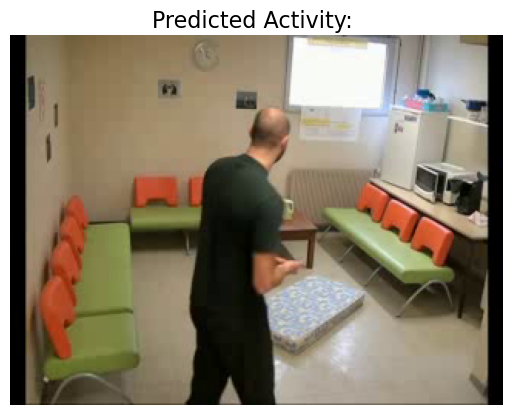

standing
standing
standing
standing
standing
standing
standing
standing
standing
standing
standing
standing


In [67]:
# ==============================
# Patient Activity Tracking - Real-Time Display
# ==============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import load_model

# ------------------------------
# 1️⃣ Load Trained Model
# ------------------------------
model = load_model("/Users/admin/Documents/MAJOR_PROJECT2/Notebook/LRCN.h5")  # Replace with your model path
CLASSES_LIST = ['FallDown', 'Lying Down','Sit down','Sitting','stand up','standing','Walking']   # Replace with your classes
SEQUENCE_LENGTH = 30  # Should match training
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # Should match training

# ------------------------------
# 2️⃣ Frame Preprocessing
# ------------------------------
def preprocess_frame(frame):
    """
    Resize and normalize a single frame
    """
    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    frame = frame / 255.0
    return frame

# ------------------------------
# 3️⃣ Open Video Capture
# ------------------------------
cap = cv2.VideoCapture("/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/Walking/video_17.avi")  # 0 = webcam, or replace with "video.avi"
frame_sequence = deque(maxlen=SEQUENCE_LENGTH)  # Stores sequence of frames

# ------------------------------
# 4️⃣ Matplotlib Setup for Real-Time Display
# ------------------------------
plt.ion()  # interactive mode
fig, ax = plt.subplots()
activity_text = ''

# ------------------------------
# 5️⃣ Real-Time Prediction Loop
# ------------------------------
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Preprocess frame
    processed = preprocess_frame(frame)
    frame_sequence.append(processed)
    
    # Make prediction once we have enough frames
    if len(frame_sequence) == SEQUENCE_LENGTH:
        input_seq = np.expand_dims(np.array(frame_sequence), axis=0)  # Shape: (1, seq_len, H, W, 3)
        preds = model.predict(input_seq, verbose=0)
        activity_index = np.argmax(preds)
        activity_text = CLASSES_LIST[activity_index]
        print(activity_text)
    
    # Display using Matplotlib
    ax.clear()
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Predicted Activity: {activity_text}", fontsize=16)
    ax.axis('off')
    plt.pause(0.001)

# Release resources
cap.release()
plt.ioff()
plt.show()


In [1]:
# ==============================
# Live Webcam Patient Activity Tracking
# ==============================

import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

# ------------------------------
# 1️⃣ Load Trained Model
# ------------------------------
model = load_model("/Users/admin/Documents/MAJOR_PROJECT2/Notebook/LRCN.h5")  # Replace with your model path
CLASSES_LIST = ['FallDown', 'Lying Down','Sit down','Sitting','stand up','standing','Walking']   # Replace with your classes
SEQUENCE_LENGTH = 30  # Should match training
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # Should match trainingg

# ------------------------------
# 2️⃣ Frame Preprocessing
# ------------------------------
def preprocess_frame(frame):
    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    frame = frame / 255.0
    return frame

# ------------------------------
# 3️⃣ Open Webcam Capture
# ------------------------------
cap = cv2.VideoCapture('/Users/admin/Documents/MAJOR_PROJECT2/Notebook/train/Stand up/video_3_flip.avi')  # 0 = default webcam
frame_sequence = deque(maxlen=SEQUENCE_LENGTH)

# ------------------------------
# 4️⃣ Real-Time Prediction Loop
# ------------------------------
while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Preprocess and append frame
    processed = preprocess_frame(frame)
    frame_sequence.append(processed)

    # Predict activity once sequence is full
    activity_text = ""
    if len(frame_sequence) == SEQUENCE_LENGTH:
        input_seq = np.expand_dims(np.array(frame_sequence), axis=0)  # Shape: (1, seq_len, H, W, 3)
        preds = model.predict(input_seq, verbose=0)
        activity_index = np.argmax(preds)
        activity_text = CLASSES_LIST[activity_index]

    # ------------------------------
    # 5️⃣ Display Video with Activity
    # ------------------------------
    display_frame = frame.copy()
    cv2.putText(display_frame,
                f"Activity: {activity_text}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    
    cv2.imshow("Patient Activity Tracking", display_frame)

    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


2025-10-03 21:20:22.894764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Failed to grab frame


In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense

model = load_model("LRCN.h5", custom_objects={
    "TimeDistributed": TimeDistributed,
    "Conv2D": Conv2D,
    "MaxPooling2D": MaxPooling2D,
    "Dropout": Dropout,
    "Flatten": Flatten,
    "LSTM": LSTM,
    "Dense": Dense
})


2025-10-03 23:40:12.540061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# After training
model.save("LRCN_model_saved.h5")   # This creates a folder


In [6]:
def load_dataset_from_dir(dataset_dir, classes_list):
    X, y = [], []
    for idx, class_name in enumerate(classes_list):
        class_dir = os.path.join(dataset_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.avi'):
                video_path = os.path.join(class_dir, file)
                sequences = extract_frames_from_avi(video_path)
                X.extend(sequences)
                y.extend([idx]*len(sequences))
    return np.array(X), np.array(y)

In [7]:
# -----------------------------
# LRCN Model
# -----------------------------
def create_LRCN_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    model.summary()
    return model


In [8]:
# -----------------------------
# Main Training Pipeline
# -----------------------------
X, y = load_dataset_from_dir('train', CLASSES_LIST)
y = to_categorical(y, num_classes=len(CLASSES_LIST))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [ ]:
#compile and train model
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 15,mode = 'min',restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ["accuracy"])

#start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train,y = labels_train,epochs = 50,batch_size = 4,
                                             shuffle = True,validation_split = 0.2,
                                             callbacks = [early_stopping_callback])

In [10]:
model = create_LRCN_model()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=8, epochs=50)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 30, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 30, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,231 (141.53 KB)

 Trainable params: 36,231 (141.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 354s 869ms/step - accuracy: 0.2561 - loss: 1.8135 - val_accuracy: 0.3123 - val_loss: 1.7452
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 312s 803ms/step - accuracy: 0.3115 - loss: 1.7337 - val_accuracy: 0.3123 - val_loss: 1.7337
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 309s 795ms/step - accuracy: 0.3260 - loss: 1.7160 - val_accuracy: 0.3226 - val_loss: 1.7198
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 318s 786ms/step - accuracy: 0.3162 - loss: 1.7164 - val_accuracy: 0.3368 - val_loss: 1.7246
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 309s 796ms/step - accuracy: 0.3326 - loss: 1.7052 - val_accuracy: 0.3419 - val_loss: 1.6995
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 312s 804ms/step - accuracy: 0.3475 - loss: 1.6742 - val_accuracy: 0.3342 - val_loss: 1.6596
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 346s 891ms/step - accuracy: 0.3614 - loss: 1.6677 - val_accuracy: 0.3690 - val_loss: 1.6530
Epoch 8/50
364/388 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3673 - los

KeyboardInterrupt: 